# 1. importation des librairies et des dataframes

## 1.1 importation des librairies

In [643]:

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import csv
import seaborn as sns
import math
import plotly.express as px
from matplotlib.collections import LineCollection
from scipy.cluster.hierarchy import dendrogram, fcluster, linkage
from sklearn import decomposition, preprocessing, metrics
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.decomposition import PCA

In [644]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None) 
sns.set(style='whitegrid')
palette = ["#b2eca7","#ffcc97","#676283","#72bbff","#d2a0f2","#0abdc0"]

## 1.2 importation des dataframes

In [645]:
complete = pd.read_csv('./sources/complete.csv')
iso3 = pd.read_csv('./sources/countries-codes.csv', sep=';')

## 2. Kmeans clustering

In [646]:
complete_scaled = preprocessing.StandardScaler().fit_transform(complete.iloc[:,1:])
idx = ["mean", "std"]
pd.DataFrame(complete_scaled).describe().round(2).loc[idx, :]

,0,1,2,3,4,5,6,7,8
mean,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,-0.0
std,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


Après reduction et centrage des données, nous avons bien une moyenne a 0, et une deviation standard de 1

### 2.1 nombre de clusters optimal

### 2.1.1 methode du coude

- La méthode du "coude": On représente graphiquement la relation entre le nombre de clusters et la somme des carrés internes (Within Cluster Sum of Squares (WCSS)) puis on sélectionne le nombre de clusters pour lequel le changement de WCSS commence à s'applatir.

Text(0, 0.5, 'WCSS')

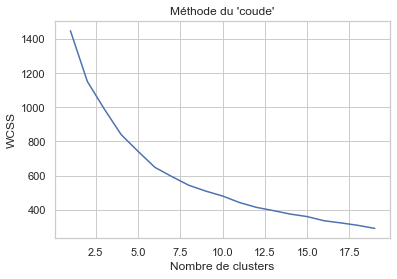

In [647]:
wcss = []
for i in range(1, 20):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(complete_scaled)
    wcss.append(kmeans.inertia_)
    
plt.plot(range(1, 20), wcss)
plt.title("Méthode du 'coude'")
plt.xlabel("Nombre de clusters")
plt.ylabel('WCSS')

La courbe semble s'aplatir a partir de 6.

### 2.1.2 methode silhouette

- La méthode "Silouhette" : Le coefficient de silouhette est la différence entre la distance moyenne avec les points du même groupe (cohésion) et la distance moyenne avec les points des groupes voisins (séparation). Le coefficient de silhouette proprement dit est la moyenne du coefficient de silhouette pour tous les points. Plus il est proche de 1 plus la classification sera bonne.

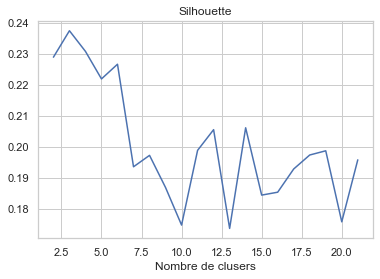

In [648]:
pd.DataFrame(complete_scaled).describe().round(2).loc[idx, :]
res = np.arange(20,dtype="double")
for k in np.arange(20):
    km = KMeans(n_clusters=k+2)
    km.fit(complete_scaled)
    res[k] = metrics.silhouette_score(complete_scaled,km.labels_)
    
plt.title("Silhouette")
plt.xlabel("Nombre de clusers")
plt.plot(np.arange(2,22,1),res)

La methode silouhette donne des resultats différents a chaque utilisation. le nombre de clusters idéal varie entre 3 et 6.

### 2.1.3 methode davies bouldin

l'indice de davies bouldin est la moyenne du rapport maximal entre la distance d'un point au centre de son groupe et la distance entre deux centres de groupes.  
L'indice de Davies-Bouldin varie entre 0 (meilleure classification) et + ∞ (pire classification).

array([[-0.30216654, -0.30304652, -1.17218203, ..., -0.88008284,
        -1.07669149, -3.12438953],
       [ 2.32150457,  0.86742094,  1.24005188, ..., -0.31247904,
        -0.94434286, -0.26105389],
       [-0.25347986, -0.30872565, -0.15538188, ..., -0.36486813,
         0.48763823,  0.48886735],
       ...,
       [ 0.20633879, 10.03807039,  2.27462825, ...,  1.90247866,
        -0.1560272 ,  0.38660536],
       [-0.45363621, -0.32746676, -1.26106316, ..., -0.88185271,
         2.38955246, -1.85179592],
       [-0.42658806, -0.33371379, -0.99975263, ..., -0.85098099,
        -0.51711337,  0.28434337]])

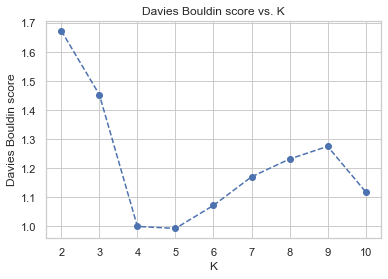

In [649]:
from sklearn.metrics import davies_bouldin_score
def get_kmeans_score(data, center):
    kmeans = KMeans(n_clusters=center)
    model = kmeans.fit_predict(complete_scaled)
    score = davies_bouldin_score(complete_scaled, model)
    return score

scores = []
centers = list(range(2,11))
for center in centers:
    scores.append(get_kmeans_score(complete_scaled, center))
    
plt.plot(centers, scores, linestyle='--', marker='o', color='b')
plt.xlabel('K')
plt.ylabel('Davies Bouldin score')
plt.title('Davies Bouldin score vs. K')
display(complete_scaled)

### 2.2 Kmeans

In [650]:
kmeans = KMeans(n_clusters=6, init='k-means++', random_state=42).fit(complete_scaled)
k_labels = kmeans.labels_
complete['cluster_km'] = k_labels

## 2.2.1 moyennes de classes

In [651]:
centroides = complete.groupby(["cluster_km"]).mean().reset_index()   # boxplot   # heatmap centroides 
display(centroides)

,cluster_km,Importations,Disponibilité intérieure,Disponibilité de protéines (g/personne/jour),Ratio importation / disponibilité interieure,Population,Pop_evo,PIB/habitant,PIB_evo,Indice stabilité politique
0,0,32.210526,419.543860,3.348421,0.155344,4.246863e+07,0.080148,7225.857895,0.098564,-0.875439
1,1,601.500000,1283.833333,11.425833,1.050885,4.485216e+07,0.043167,57955.216667,0.027465,0.494167
2,2,63.000000,14124.000000,17.805000,0.003517,2.664593e+08,0.030631,37219.700000,-0.009647,-0.090000
3,3,50.311475,360.262295,10.852787,0.419777,1.198354e+07,0.015012,30141.783607,0.102685,0.565902
4,4,0.000000,3661.000000,0.750000,0.000000,1.338677e+09,0.045154,6182.900000,0.283159,-0.760000
5,5,50.464286,67.285714,4.365714,0.969596,5.865759e+06,0.105089,8962.607143,-0.003699,0.082143


Le cluster 0 est celui la moyenne d'importations de volailles et le pib/habitant est le plus elevé.  
L'indice de stabilité politique est satisfaisant.  
Cela semble etre le cluster idéal.

<AxesSubplot:xlabel='cluster_km', ylabel='PIB/habitant'>

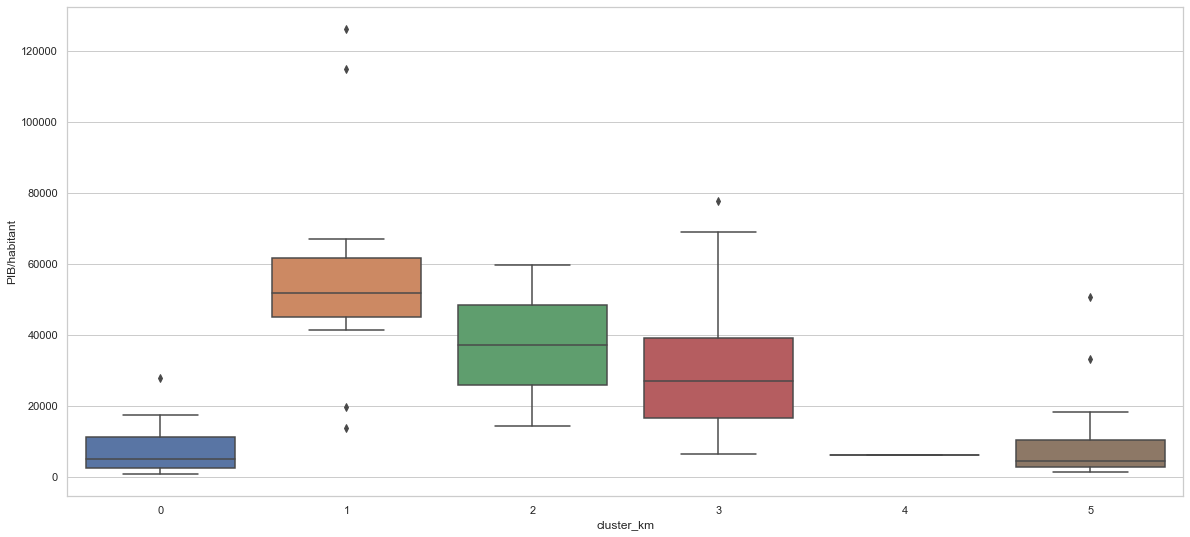

In [652]:
fig, ax = plt.subplots(figsize=(20, 9))
sns.boxplot(data=complete,x='cluster_km', y='PIB/habitant')

<AxesSubplot:xlabel='cluster_km', ylabel='Importations'>

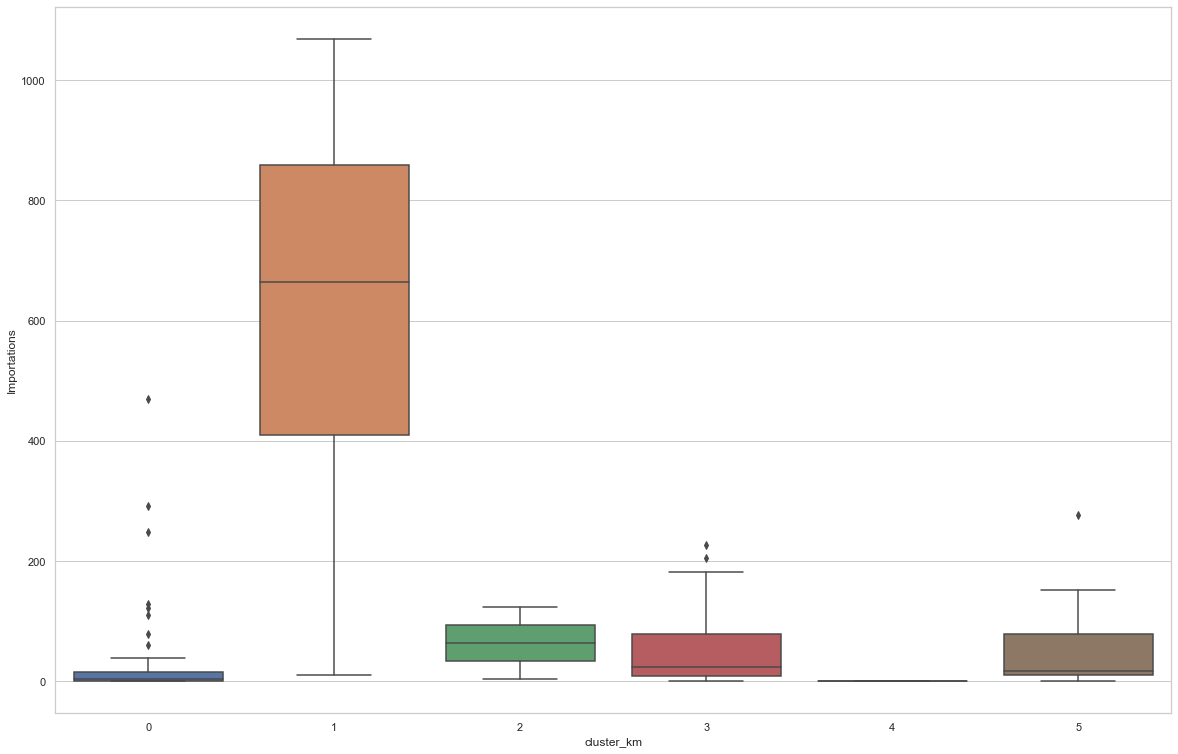

In [653]:
fig, ax = plt.subplots(figsize=(20, 13))
sns.boxplot(data=complete,x='cluster_km', y='Importations')

<AxesSubplot:xlabel='cluster_km', ylabel='Indice stabilité politique'>

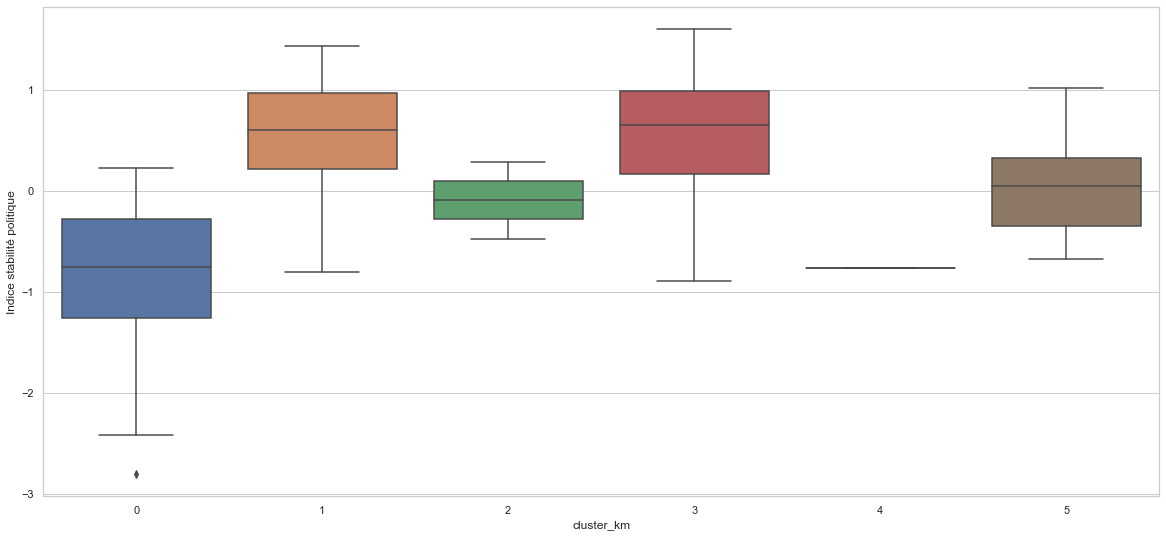

In [654]:
fig, ax = plt.subplots(figsize=(20, 9))
sns.boxplot(data=complete,x='cluster_km', y='Indice stabilité politique')

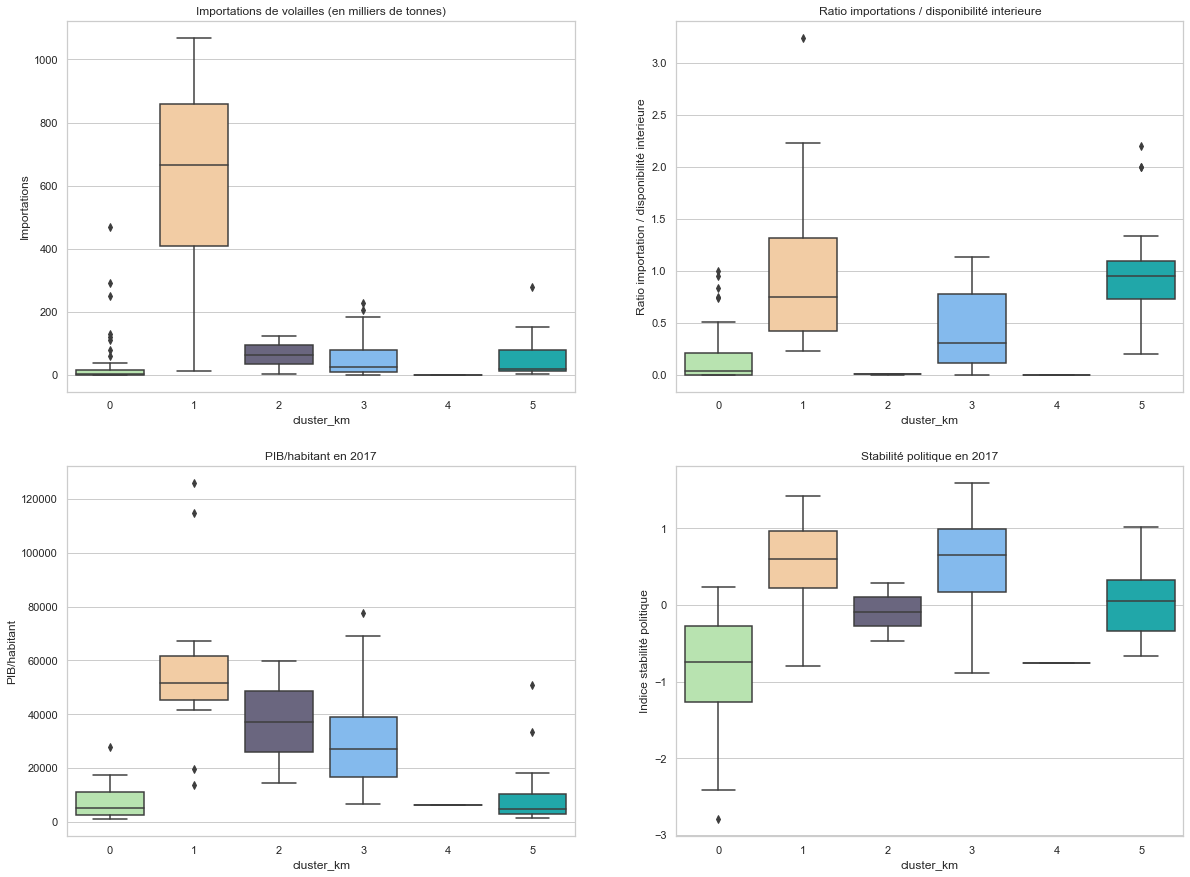

In [655]:
#Comparaison visuelle des groupes par Boxplot, en abscisse les numéros des groupes
plt.figure(figsize=(20, 15))
sns.set(style="whitegrid", palette=palette)

plt.subplot(221)
sns.boxplot(data=complete, x='cluster_km', y='Importations')
plt.title('Importations de volailles (en milliers de tonnes)')

plt.subplot(222)
sns.boxplot(data=complete, x='cluster_km', y='Ratio importation / disponibilité interieure')
plt.title('Ratio importations / disponibilité interieure')


plt.subplot(223)
sns.boxplot(data=complete, x='cluster_km', y='PIB/habitant')
plt.title('PIB/habitant en 2017')

plt.subplot(224)
sns.boxplot(data=complete, x='cluster_km', y='Indice stabilité politique')
plt.title('Stabilité politique en 2017')

plt.show()

<AxesSubplot:>

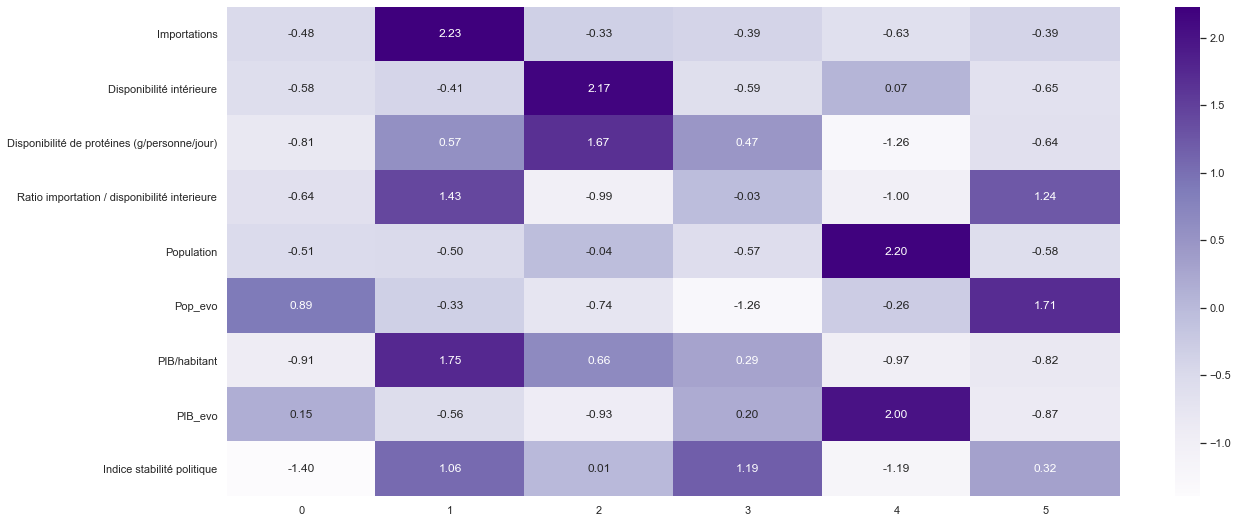

In [656]:
fig, ax = plt.subplots(figsize=(20, 9))
hm_centroides = preprocessing.StandardScaler().fit_transform(centroides.iloc[:,1:])
hm_centroides = pd.DataFrame(hm_centroides)
hm_centroides = hm_centroides.T
hm_centroides.index = centroides.columns[1:]
sns.heatmap(hm_centroides, annot=True, cmap="Purples", fmt="0.2f")

## 3. ACP

### 3.1 eboulis des valeurs propres

[28.4 19.1 15.1 10.5  7.7  6.2  5.2  4.4  3.5]


Text(0.5, 1.0, 'Eboulis des valeurs propres')

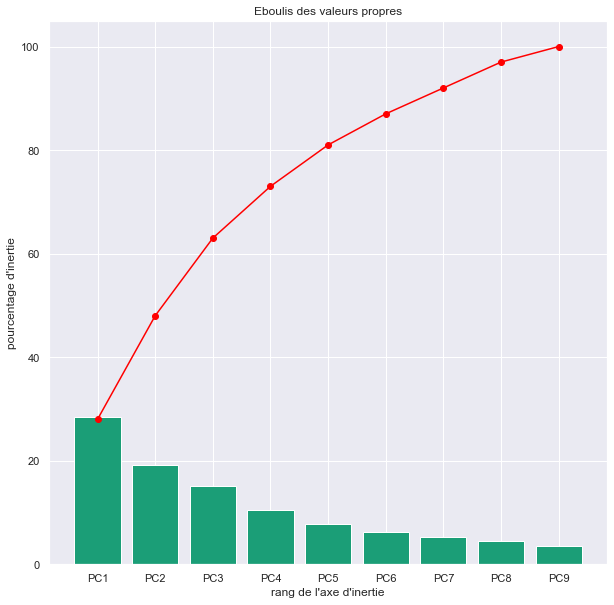

In [657]:
sns.set(palette='Dark2')
pca = PCA()
pca.fit(complete_scaled)
pca_data = pca.transform(complete_scaled)
var = np.round(pca.explained_variance_ratio_* 100, decimals=1)
scree = var.cumsum().round()
labels = ['PC' + str(x) for x in range(1, len(var) + 1)]
print(var)
plt.figure(figsize=(10, 10))
plt.plot(range(1, len(var) + 1), scree, c="red",marker='o')
plt.bar(x=range(1, len(var) + 1), height=var, tick_label=labels)
plt.xlabel("rang de l'axe d'inertie")
plt.ylabel("pourcentage d'inertie")
plt.title("Eboulis des valeurs propres")

### 3.2 tableau de corrélations

<AxesSubplot:>

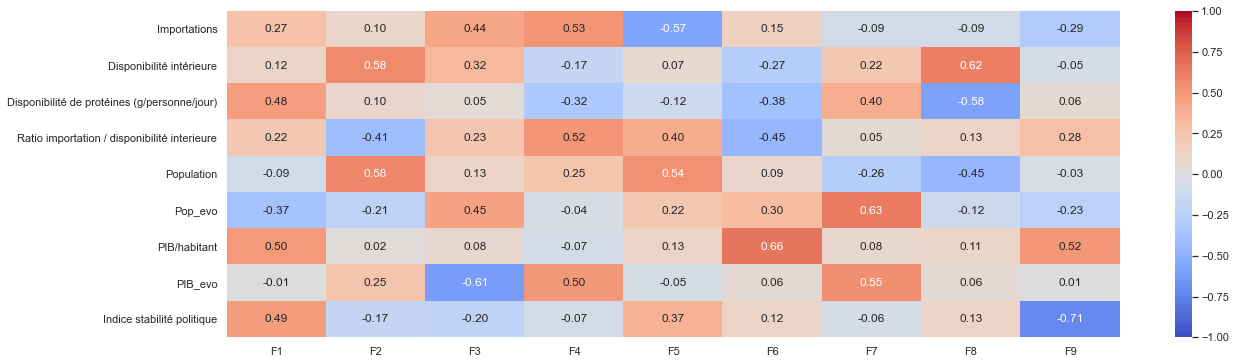

In [658]:
features = complete.columns[:-1]
pcs = pca.components_
pcs = pd.DataFrame(pcs)
pcs.columns = features[1:]
pcs.index = [f"F{i}" for i in range(1, len(var) + 1)]
pcs.round(2)
fig, ax = plt.subplots(figsize=(20, 6))
sns.heatmap(pcs.T, vmin=-1, vmax=1, annot=True, cmap="coolwarm", fmt="0.2f")

### 3.3 Cercles de corrélations

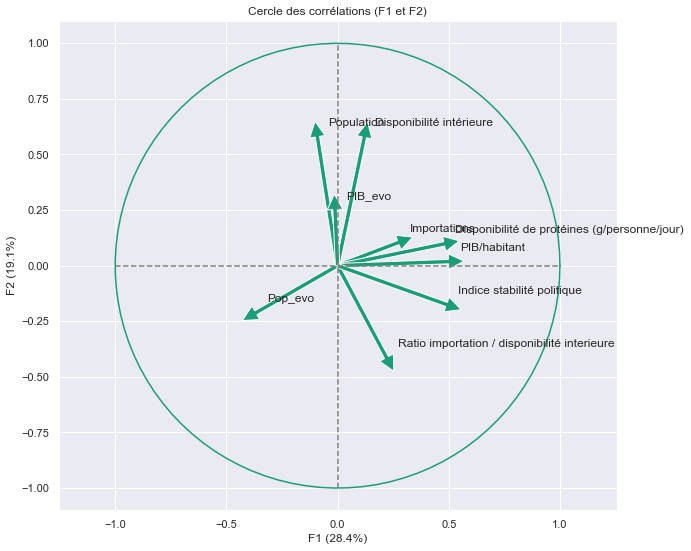

<Figure size 7200x7200 with 0 Axes>

In [659]:
x, y = 0,1
fig, ax = plt.subplots(figsize=(10, 9))
for i in range(0, pca.components_.shape[1]):
    ax.arrow(0,
             0,
             pca.components_[x, i],  #0 for PC1
             pca.components_[y, i],  #1 for PC2
             head_width=0.07,
             head_length=0.07, 
             width=0.02,              )

    plt.text(pca.components_[x, i] + 0.05,
             pca.components_[y, i] + 0.05,
             features[i+1])
    
plt.plot([-1, 1], [0, 0], color='grey', ls='--')
plt.plot([0, 0], [-1, 1], color='grey', ls='--')

plt.xlabel('F{} ({}%)'.format(x+1, round(100*pca.explained_variance_ratio_[x],1)))
plt.ylabel('F{} ({}%)'.format(y+1, round(100*pca.explained_variance_ratio_[y],1)))

plt.title("Cercle des corrélations (F{} et F{})".format(x+1, y+1))


an = np.linspace(0, 2 * np.pi, 100)
plt.plot(np.cos(an), np.sin(an))
plt.axis('equal')
plt.figure(figsize=(100, 100))
plt.show(block=False)

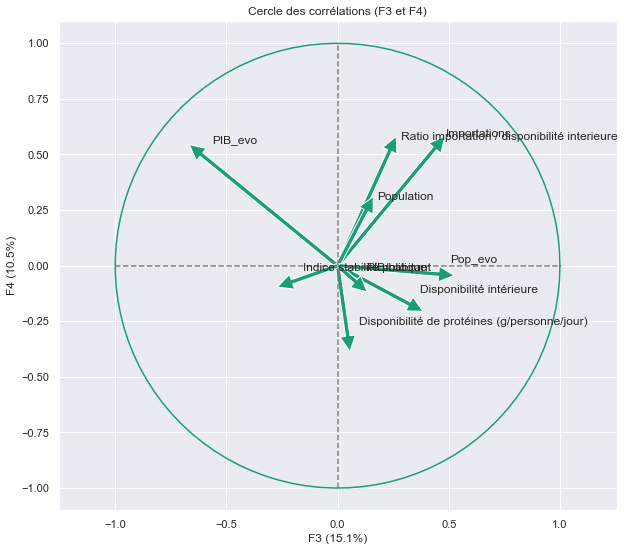

<Figure size 7200x7200 with 0 Axes>

In [660]:
x, y = 2,3
fig, ax = plt.subplots(figsize=(10, 9))
for i in range(0, pca.components_.shape[1]):
    ax.arrow(0,
             0,  # Start the arrow at the origin
             pca.components_[x, i],  #2 for PC3
             pca.components_[y, i],  #3 for PC4
             head_width=0.07,
             head_length=0.07, 
             width=0.02,              )

    plt.text(pca.components_[x, i] + 0.05,
             pca.components_[y, i] + 0.05,
             features[i+1])
    
# affichage des lignes horizontales et verticales
plt.plot([-1, 1], [0, 0], color='grey', ls='--')
plt.plot([0, 0], [-1, 1], color='grey', ls='--')


# nom des axes, avec le pourcentage d'inertie expliqué
plt.xlabel('F{} ({}%)'.format(x+1, round(100*pca.explained_variance_ratio_[x],1)))
plt.ylabel('F{} ({}%)'.format(y+1, round(100*pca.explained_variance_ratio_[y],1)))

plt.title("Cercle des corrélations (F{} et F{})".format(x+1, y+1))


an = np.linspace(0, 2 * np.pi, 100)
plt.plot(np.cos(an), np.sin(an))  # Add a unit circle for scale
plt.axis('equal')
plt.figure(figsize=(100, 100))
plt.show(block=False)
# projeter les pays sur les 2 1er axe factoriel + centroides + conclusion pays /cluster

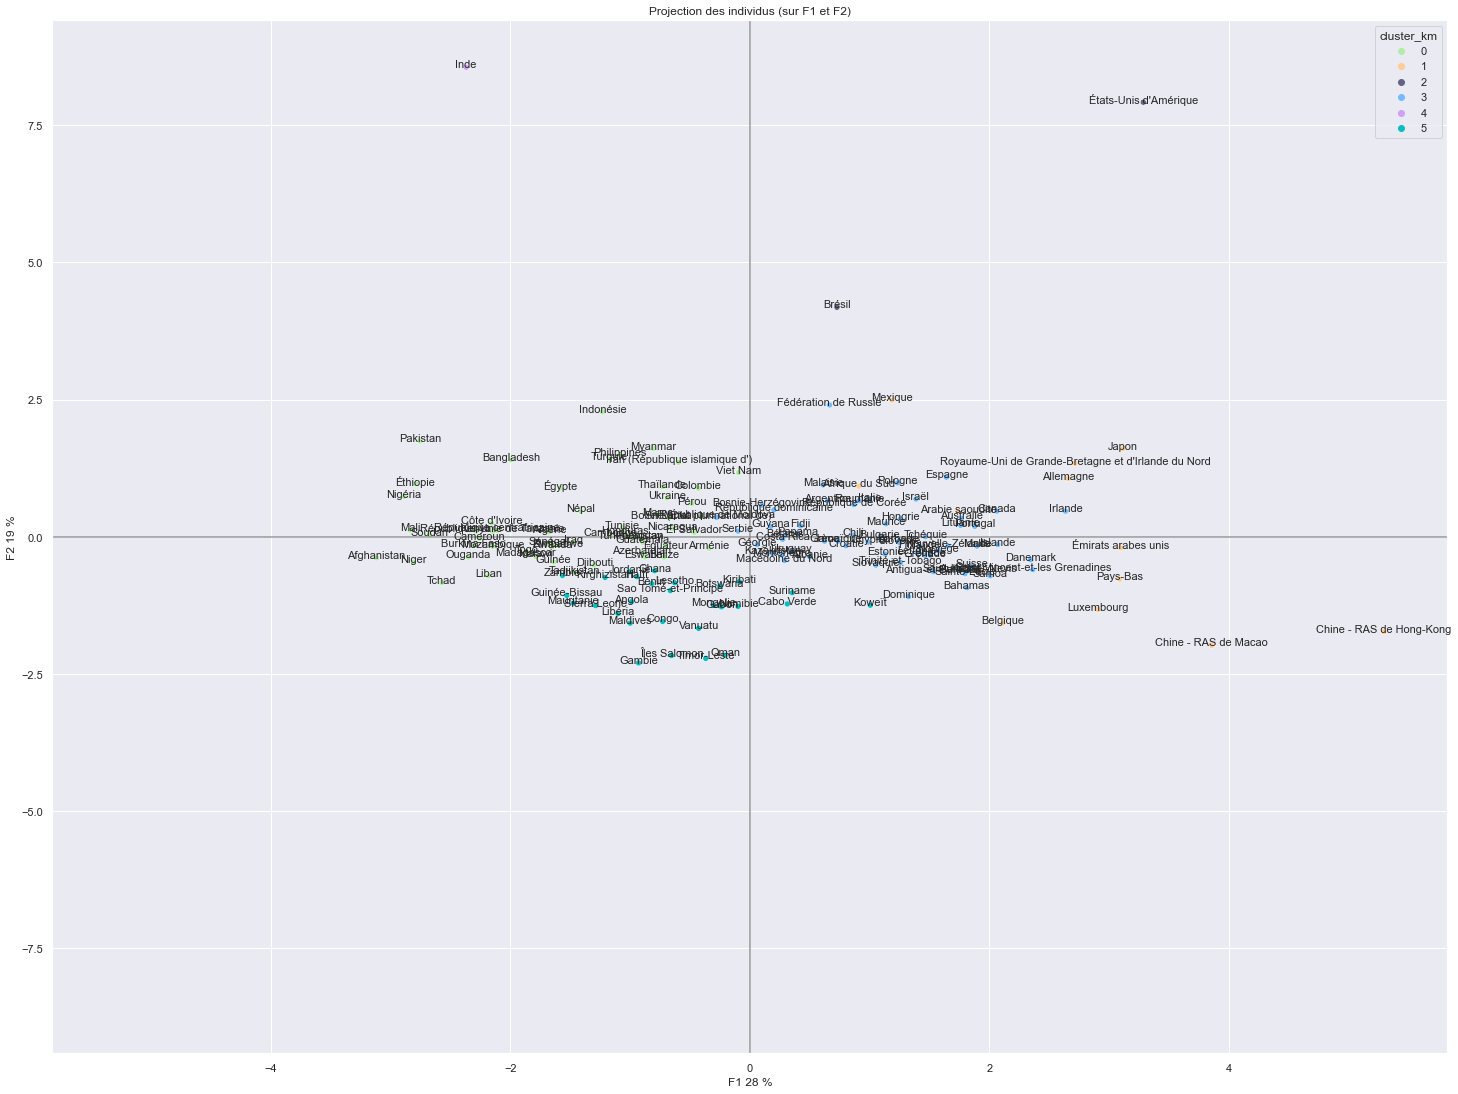

In [661]:
def display_factorial_planes(   X_projected, 
                                x_y, 
                                pca=None, 
                                labels = None,
                                clusters=None, 
                                alpha=1,
                                figsize=[16,9], 
                                marker="." ):
    
    palette = ["#b2eca7","#ffcc97","#676283","#72bbff","#d2a0f2","#0abdc0"]

    # Transforme X_projected en np.array
    X_ = np.array(X_projected)

    # On définit la forme de la figure si elle n'a pas été donnée
    if not figsize: 
        figsize = (7,6)

    # On gère les labels
    if  labels is None : 
        labels = []
    try : 
        len(labels)
    except Exception as e : 
        raise e

    # On vérifie la variable axis 
    if not len(x_y) ==2 : 
        raise AttributeError("2 axes sont demandées")   
    if max(x_y )>= X_.shape[1] : 
        raise AttributeError("la variable axis n'est pas bonne")   

    # on définit x et y 
    x, y = x_y

    # Initialisation de la figure       
    fig, ax = plt.subplots(1, 1, figsize=figsize)

    # On vérifie s'il y a des clusters ou non
    c = None if clusters is None else clusters
 
    # Les points    
    sns.scatterplot(data=None, x=X_[:, x], y=X_[:, y], hue=c, palette=palette)

    # Si la variable pca a été fournie, on peut calculer le % de variance de chaque axe 
    if pca : 
        v1 = str(round(100*pca.explained_variance_ratio_[x]))  + " %"
        v2 = str(round(100*pca.explained_variance_ratio_[y]))  + " %"
    else : 
        v1=v2= ''

    # Nom des axes, avec le pourcentage d'inertie expliqué
    ax.set_xlabel(f'F{x+1} {v1}')
    ax.set_ylabel(f'F{y+1} {v2}')

    # Valeur x max et y max
    x_max = np.abs(X_[:, x]).max() *1.1
    y_max = np.abs(X_[:, y]).max() *1.1

    # On borne x et y 
    ax.set_xlim(left=-x_max, right=x_max)
    ax.set_ylim(bottom= -y_max, top=y_max)

    # Affichage des lignes horizontales et verticales
    plt.plot([-x_max, x_max], [0, 0], color='grey', alpha=0.8)
    plt.plot([0,0], [-y_max, y_max], color='grey', alpha=0.8)

    # Affichage des labels des points
    if len(labels) : 
        for i,(_x,_y) in enumerate(X_[:,[x,y]]):
            plt.text(_x, _y+0.05, labels[i], fontsize='11', ha='center',va='center') 

    # Titre et display
    plt.title(f"Projection des individus (sur F{x+1} et F{y+1})")
    plt.show()
n_comp = 6

x_y = [0,1]
display_factorial_planes(pca_data, x_y, pca, labels=complete['Zone'], figsize=(25,19), clusters=complete['cluster_km'], marker="o")

plt.show()

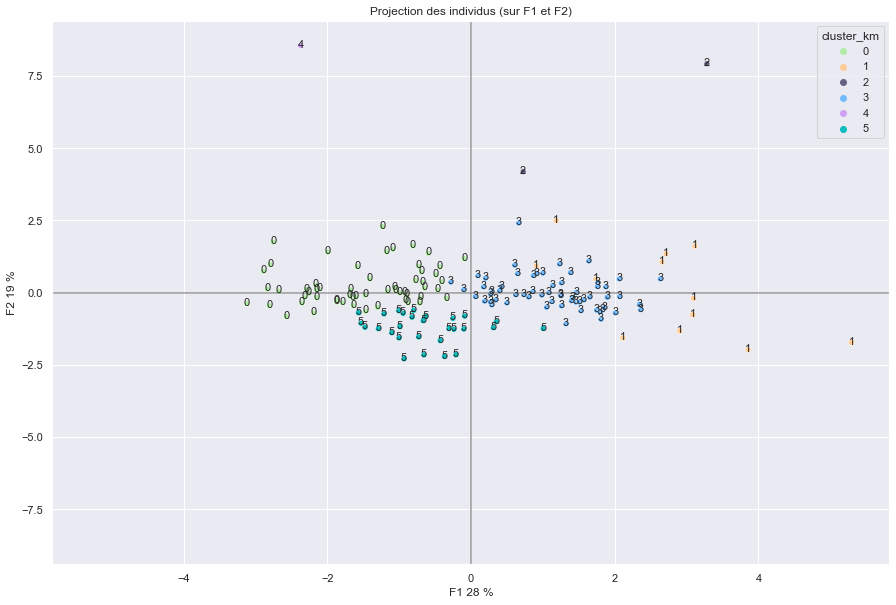

In [662]:
x_y = [0,1]
display_factorial_planes(pca_data, x_y, pca, labels=complete['cluster_km'], figsize=(15,10), clusters=complete['cluster_km'], marker="o")

plt.show()

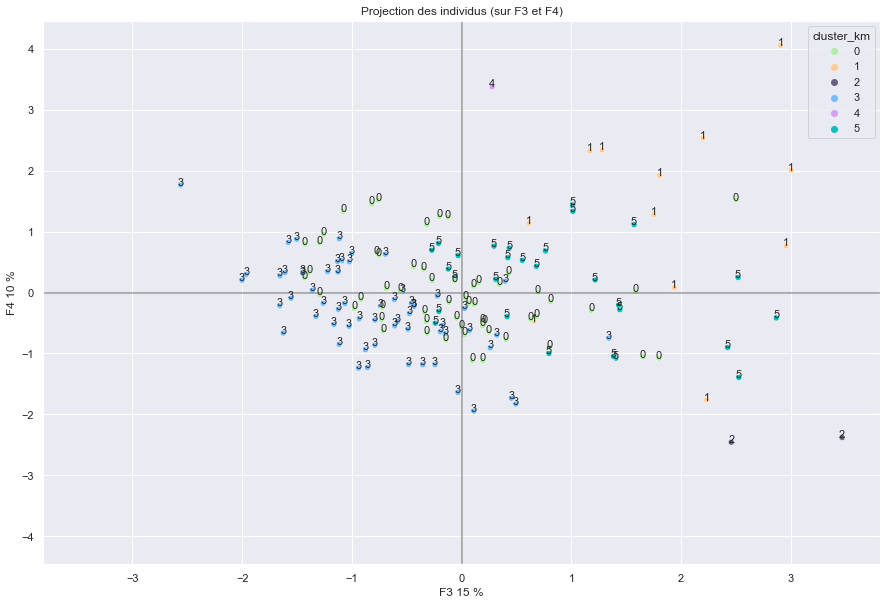

In [663]:
x_y = [2,3]
display_factorial_planes(pca_data, x_y, pca, labels=complete['cluster_km'], figsize=(15,10), clusters=complete['cluster_km'], marker="o")

plt.show()

In [664]:
palette = ["#b2eca7","#ffcc97","#676283","#72bbff","#d2a0f2","#0abdc0"]
iso3 = iso3.rename(columns={'LABEL FR': 'Zone'})
iso3 = iso3[['Zone', 'ISO3 CODE']]
complete['cluster_km'] = complete['cluster_km'].apply(str)
complete_visu = pd.merge(complete, iso3, on='Zone', how='inner')
complete_visu.info()
px.choropleth(complete_visu, locations="ISO3 CODE",
                    color='cluster_km',
                    hover_name="Zone",
                    color_discrete_sequence=palette,
                    basemap_visible=True,
                    title= "Répartition géographiques des clusters obtenus par Kmeans")

<class 'pandas.core.frame.DataFrame'>
Int64Index: 161 entries, 0 to 160
Data columns (total 12 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   Zone                                          161 non-null    object 
 1   Importations                                  161 non-null    float64
 2   Disponibilité intérieure                      161 non-null    float64
 3   Disponibilité de protéines (g/personne/jour)  161 non-null    float64
 4   Ratio importation / disponibilité interieure  161 non-null    float64
 5   Population                                    161 non-null    float64
 6   Pop_evo                                       161 non-null    float64
 7   PIB/habitant                                  161 non-null    float64
 8   PIB_evo                                       161 non-null    float64
 9   Indice stabilité politique                    161 non-null    flo

## 4. Classification ascendante hierarchique

[[85, 87, 1.0, 1], [23, 28, 2.0, 2], [118, 138, 3.0, 3], [55, 139, 4.0, 4], [97, 144, 5.0, 5], [74, 162, 6.0, 6], [56, 93, 7.0, 7], [6, 124, 8.0, 8], [84, 96, 9.0, 9], [60, 91, 10.0, 10], [27, 147, 11.0, 11], [11, 137, 12.0, 12], [33, 132, 13.0, 13], [3, 154, 14.0, 14], [17, 157, 15.0, 15], [44, 131, 16.0, 16], [58, 169, 17.0, 17], [50, 160, 18.0, 18], [110, 134, 19.0, 19], [25, 51, 20.0, 20], [34, 64, 21.0, 21], [125, 127, 22.0, 22], [103, 135, 23.0, 23], [26, 99, 24.0, 24], [61, 113, 25.0, 25], [59, 78, 26.0, 26], [2, 22, 27.0, 27], [18, 100, 28.0, 28], [75, 128, 29.0, 29], [46, 92, 30.0, 30], [115, 170, 31.0, 31], [141, 173, 32.0, 32], [69, 120, 33.0, 33], [123, 163, 34.0, 34], [101, 107, 35.0, 35], [36, 109, 36.0, 36], [12, 146, 37.0, 37], [15, 70, 38.0, 38], [37, 176, 39.0, 39], [42, 45, 40.0, 40], [165, 166, 41.0, 41], [67, 104, 42.0, 42], [19, 121, 43.0, 43], [126, 168, 44.0, 44], [40, 164, 45.0, 45], [143, 178, 46.0, 46], [105, 179, 47.0, 47], [10, 29, 48.0, 48], [86, 122, 49.0

Text(0.5, 1.0, 'Dendrogramme')

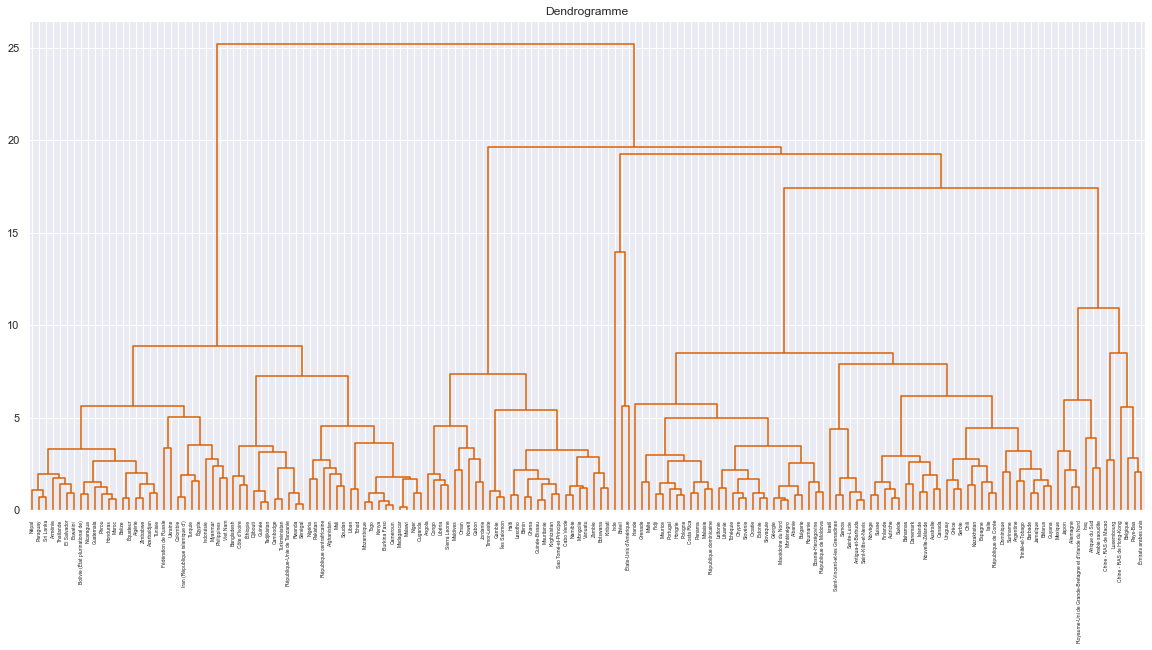

In [665]:
sns.set(palette='Dark2')
complete_scaled = preprocessing.StandardScaler().fit_transform(complete.iloc[:,1:])
ward = AgglomerativeClustering(linkage='ward', compute_full_tree=True).fit(complete_scaled)
#complete = complete.set_index(['Zone'])
Z = linkage(complete_scaled, method = 'ward', metric='euclidean')
dendro = [ ]
for a,b in ward.children_:
    dendro.append([a, b, float(len(dendro)+1), (len(dendro)+1)])
print(dendro)
plt.figure(figsize=(20, 9))
dendrogram(Z, labels=list(complete['Zone']), color_threshold=155, show_leaf_counts=True,orientation="top")
plt.title("Dendrogramme")

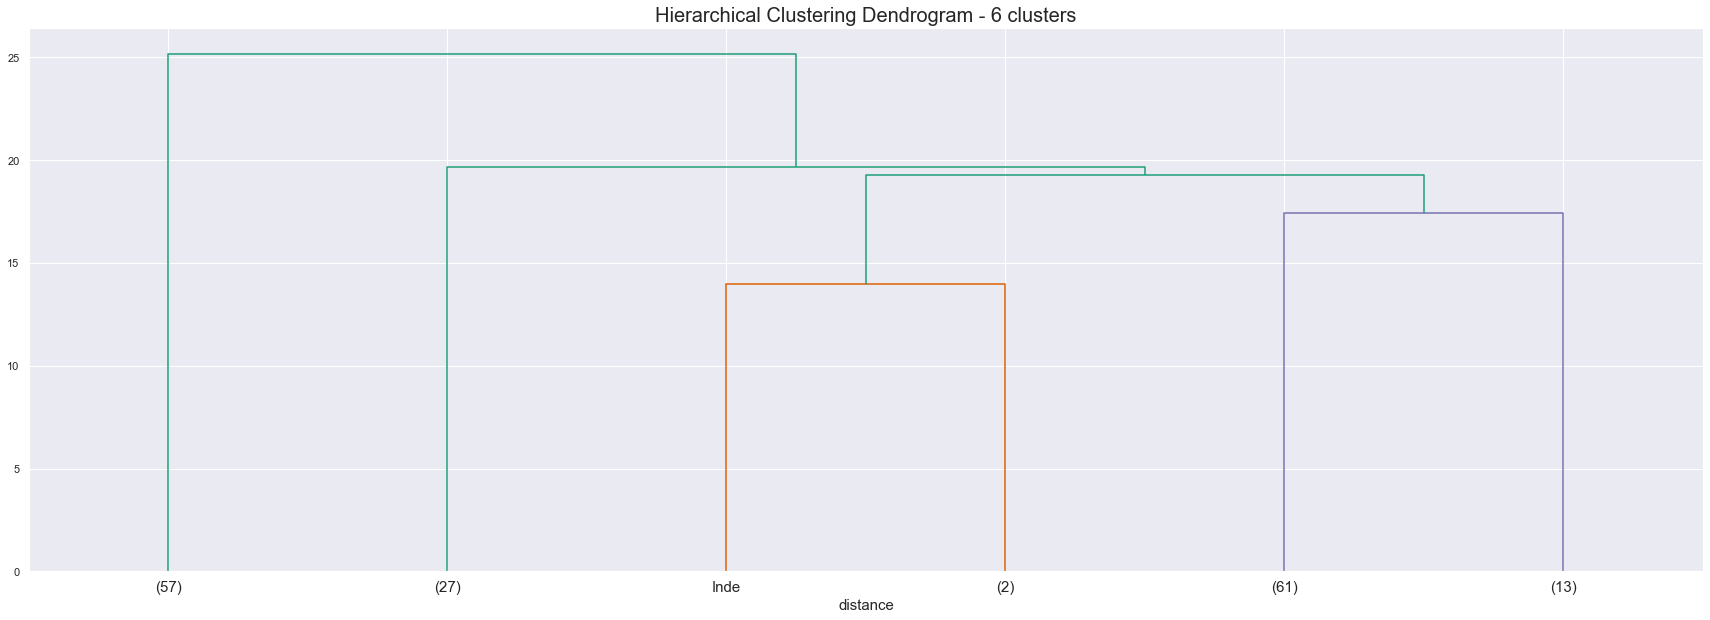

In [666]:

fig = plt.figure(figsize=(30,10))
plt.title('Hierarchical Clustering Dendrogram - 6 clusters', fontsize=20)
plt.xlabel('distance', fontsize=15)

dendrogram(Z, labels=list(complete['Zone']), p=6, truncate_mode='lastp', leaf_font_size=15, orientation='top')
plt.show()

In [667]:
complete["cluster_cah"] = fcluster(dendro,t=155,criterion='distance')
complete["cluster_cah"] = complete["cluster_cah"].apply(str)
iso3 = iso3.rename(columns={'LABEL FR': 'Zone'})
iso3 = iso3[['Zone', 'ISO3 CODE']]
complete_visu = pd.merge(complete, iso3, on='Zone', how='inner')
complete_visu.info()
px.choropleth(complete_visu, locations="ISO3 CODE",
                    color="cluster_cah",
                    hover_name="Zone",
                    color_discrete_sequence=palette,
                    basemap_visible=True,
                    title= "Répartition géographiques des clusters obtenus par classification ascendante hiérarchique")

<class 'pandas.core.frame.DataFrame'>
Int64Index: 161 entries, 0 to 160
Data columns (total 13 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   Zone                                          161 non-null    object 
 1   Importations                                  161 non-null    float64
 2   Disponibilité intérieure                      161 non-null    float64
 3   Disponibilité de protéines (g/personne/jour)  161 non-null    float64
 4   Ratio importation / disponibilité interieure  161 non-null    float64
 5   Population                                    161 non-null    float64
 6   Pop_evo                                       161 non-null    float64
 7   PIB/habitant                                  161 non-null    float64
 8   PIB_evo                                       161 non-null    float64
 9   Indice stabilité politique                    161 non-null    flo

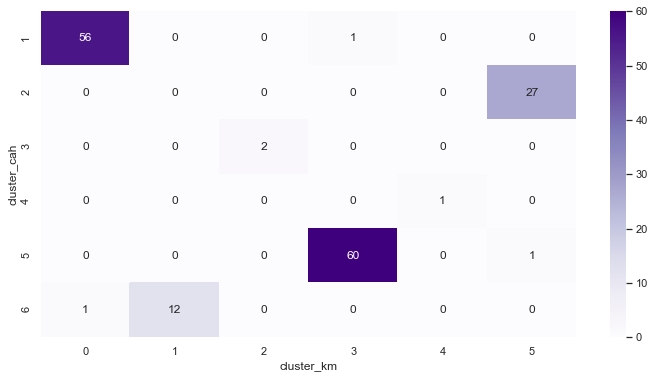

In [668]:
Crosstab = pd.crosstab(complete["cluster_cah"], complete['cluster_km'])
Crosstab
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
ax = sns.heatmap(data=Crosstab, cmap='Purples', annot=True)

## liste des pays du cluster choisi

In [669]:
clus = complete.loc[complete['cluster_km']=="1"]
display(clus)

,Zone,Importations,Disponibilité intérieure,Disponibilité de protéines (g/personne/jour),Ratio importation / disponibilité interieure,Population,Pop_evo,PIB/habitant,PIB_evo,Indice stabilité politique,cluster_km,cluster_cah
1,Afrique du Sud,514.0,2118.0,14.11,0.242682,57009756.0,0.061889,13860.3,-0.014631,-0.28,1,6
4,Allemagne,842.0,1739.0,7.96,0.484186,82658409.0,0.018282,53071.5,0.062403,0.59,1,6
7,Arabie saoudite,722.0,1435.0,15.57,0.503136,33101179.0,0.101461,47306.2,-0.011332,-0.64,1,6
16,Belgique,338.0,152.0,4.57,2.223684,11419748.0,0.023825,50442.3,0.046421,0.43,1,6
31,Chine - RAS de Hong-Kong,907.0,280.0,22.26,3.239286,7306322.0,0.030689,59842.2,0.083517,0.83,1,6
32,Chine - RAS de Macao,23.0,19.0,11.90,1.210526,622585.0,0.078308,126144.0,-0.221199,1.43,1,6
71,Japon,1069.0,2415.0,7.24,0.442650,127502725.0,-0.006324,41444.2,0.047375,1.11,1,6
83,Luxembourg,11.0,11.0,7.19,1.000000,591910.0,0.090958,114986.0,0.017116,1.33,1,6
94,Mexique,972.0,4219.0,9.26,0.230386,124777324.0,0.050074,19721.3,0.060262,-0.80,1,6
111,Pays-Bas,608.0,372.0,8.48,1.634409,17021347.0,0.010559,55088.6,0.066779,0.92,1,6
